# Team Project #4 - Spatial Estimation
## Dr. Pyrcz's Stochastic Method for Reservoir Modeling
## Team 4: Qiqi Wang, Jiacheng Wang, Yanli pei, Honggeun Jo



## Objectives
### 1. Apply indicator kriging for facies to calculate the propability of each facies across the reservoir
               
### 2. Apply oridnary kriging for porosity and permeability to calculate the kriging estimate and variance (by-facies)

### 3. Build a combined model with porosity and permeability (cookie-cutter approach)

### 4. Report local P10 and P90 map for porosity and permeability at all locations (probability of each facies, CDF)

### 5. Pick 2 candidate well locations and provide a predrill porosity uncertainty distribution (linear family of distribution models)

# 0. Load package, initial setting, and fetching data

In [1]:
## Import needed package
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from scipy import stats                                     # summary stats
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import seaborn as sns
import scipy.stats as st                               # statistical methods
import scipy.signal as signal             # kernel for moving window calculation
import random
import math  

## Set Working Directory
os.chdir("D:/UT Course/Spring2019/Stoch Meth/Update#4")  # set the working directory

# Load Data 
df = pd.read_csv("4_sample_data.csv")                       # well sample data
#AI_map = np.loadtxt("4_AI.csv", delimiter = ",")            # AI map
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records

It seems that the first column seems not needed...

In [2]:
df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,5,70.0,580.0,1.0,0.102475,30.149009,3477.934210
1,15,140.0,860.0,1.0,0.086987,8.540175,3500.807463
2,22,140.0,370.0,1.0,0.091117,266.893061,3478.303116
3,23,140.0,300.0,1.0,0.097404,5.483678,3428.434722
4,24,140.0,230.0,1.0,0.089087,29.146330,3853.554854


In [3]:
df.describe().transpose()                          # summary table of all facies combined DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,178.0,282.668539,156.940549,5.000000,167.500000,266.500000,426.500000,563.000000
X,178.0,470.393258,239.548451,0.000000,300.000000,480.000000,630.000000,980.000000
Y,178.0,636.977528,272.854465,9.000000,442.250000,719.500000,864.000000,999.000000
Facies,178.0,0.887640,0.316699,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,178.0,0.122491,0.035144,0.078601,0.091162,0.116853,0.151399,0.186311
Perm,178.0,162.372756,585.370901,0.027218,5.745164,23.820284,90.555638,5689.823420
AI,178.0,3115.424695,798.465526,1759.403262,2439.938679,2937.328224,3787.043657,5124.532354


In [4]:
df_sand.describe().transpose()                     # summary table of sand only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,158.0,87.278481,51.309958,0.000000,43.750000,85.500000,131.750000,177.000000
Unnamed: 0,158.0,278.949367,156.233404,5.000000,155.500000,261.500000,424.250000,563.000000
X,158.0,452.215190,222.892460,10.000000,292.500000,475.000000,602.500000,980.000000
Y,158.0,678.708861,235.287608,9.000000,526.500000,739.000000,867.750000,999.000000
Facies,158.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Porosity,158.0,0.126750,0.035001,0.079210,0.092165,0.122782,0.158212,0.186311
Perm,158.0,180.220811,619.080385,0.027218,7.482659,26.373074,106.854123,5689.823420
AI,158.0,2958.664034,693.430024,1759.403262,2383.633549,2860.908860,3478.210889,4516.534318


In [5]:
df_shale.describe().transpose()                    # summary table of shale only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,20.0,98.150000,53.572651,8.000000,44.750000,100.000000,143.250000,175.000000
Unnamed: 0,20.0,312.050000,163.501964,41.000000,174.500000,301.500000,460.250000,555.000000
X,20.0,614.000000,315.584670,0.000000,410.000000,710.000000,872.500000,950.000000
Y,20.0,307.300000,327.438881,20.000000,46.500000,194.500000,476.500000,979.000000
Facies,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Porosity,20.0,0.088845,0.006369,0.078601,0.083631,0.090610,0.093412,0.097991
Perm,20.0,21.373123,40.267366,0.212234,1.200728,2.866398,16.343926,130.115998
AI,20.0,4353.833915,383.703071,3771.938792,4139.550650,4256.907099,4659.196986,5124.532354


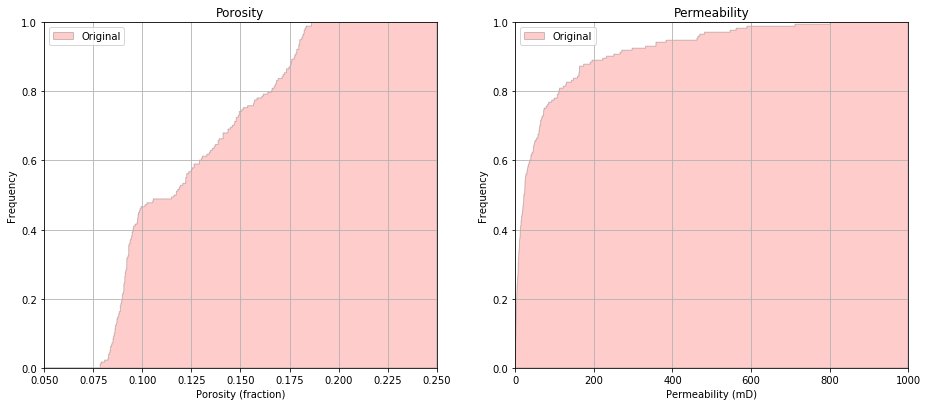

In [6]:
plt.subplot(121)                                        # plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='red',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot original sand and shale permeability histograms
plt.hist(df['Perm'], facecolor='red',bins=np.linspace(0.0,1000.0,100000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]); plt.ylim([0,1.0])
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

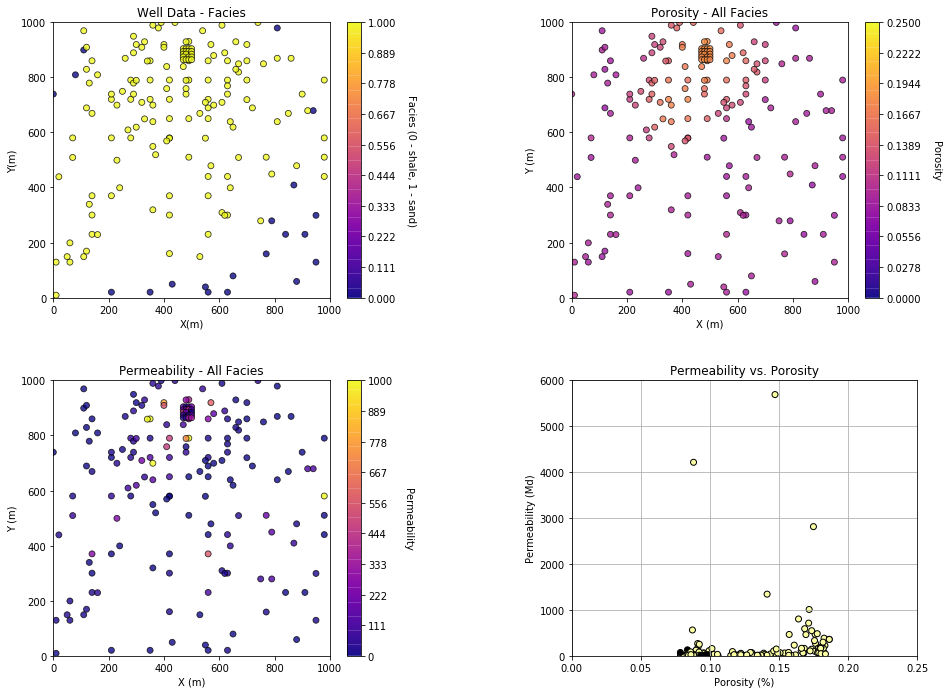

In [7]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

cmap = plt.cm.plasma                    # color map
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - All Facies','X (m)','Y (m)','Permeability',cmap)

plt.subplot(224)
facies = df['Facies'].values +0.01
plt.scatter(df['Porosity'],df['Perm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Porosity (%)')
plt.ylabel(r'Permeability (Md)')
plt.title('Permeability vs. Porosity')
plt.xlim([0,0.25])
plt.ylim([0,6000])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)
plt.show()

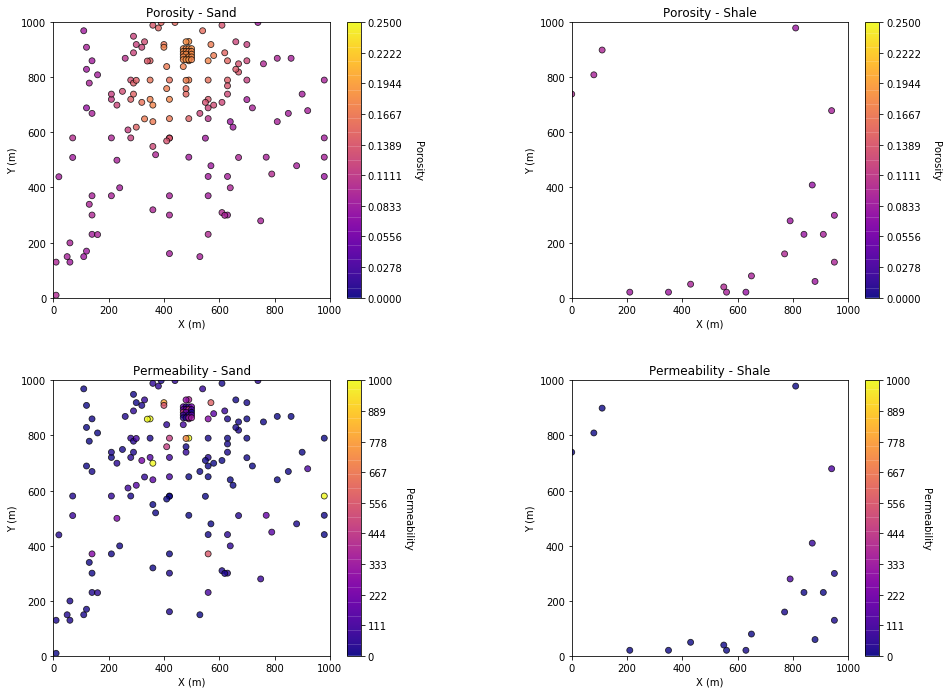

In [8]:
plt.subplot(221)
GSLIB.locmap_st(df_sand,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Sand','X (m)','Y (m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locmap_st(df_shale,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Shale','X (m)','Y (m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df_sand,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Sand','X (m)','Y (m)','Permeability',cmap)

plt.subplot(224)
GSLIB.locmap_st(df_shale,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Shale','X (m)','Y (m)','Permeability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)
plt.show()

# 1. Indicator Kriging for Facies

In [9]:
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

In [10]:
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.25,0.75]                         # the global proportions of the categories (from update #2)
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=2,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=3,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=2,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=3,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # sand indicator variogram

Data for IK3D: Variable column Facies
  Number   = 178
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


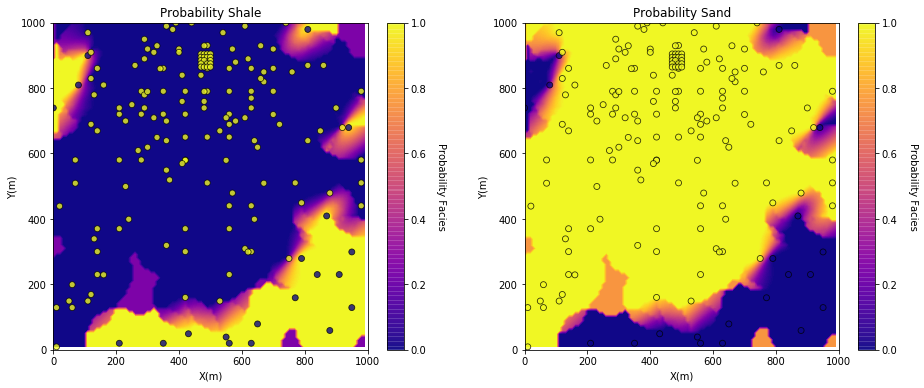

In [11]:
no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,radius,ktype,vario=varios)

plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2) 
plt.show()

# 2. Ordinary Kriging for Porosity and Permeability (by-facies)


### 2-1) Combined

In [12]:
skmean_por = 0.12; skmean_perm = 162.4  # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value
por_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=22.5,hmaj1=100,hmin1=50,it2=3,cc2=0.8,azi2=22.5,hmaj2=900,hmin2=300) # porosity variogram
perm_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.4,azi1=45,hmaj1=150,hmin1=100,it2=3,cc2=0.6,azi2=45,hmaj2=900,hmin2=180) # permeability variogram

  Estimated   10000 blocks 
      average   0.1021665514858455  variance  0.0005544846243691441
  Estimated   10000 blocks 
      average   53.36898449070016  variance  6845.9929935955115


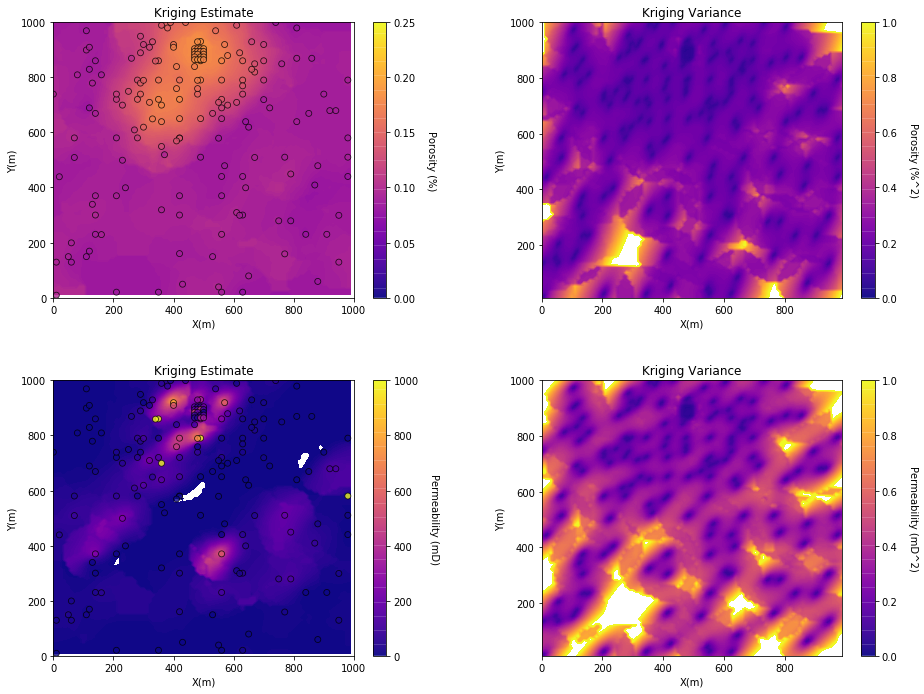

In [13]:
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

perm_kmap, perm_vmap = geostats.kb2d(df,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm,perm_vario)

plt.subplot(221)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','Perm','Kriging Estimate','X(m)','Y(m)','Permeability (mD)',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(perm_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Permeability (mD^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

### 2-2) By-facies

In [14]:
skmean_por_sand = 0.13; skmean_por_shale = 0.09
skmean_perm_sand = 180.2; skmean_perm_shale = 21.4
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value

por_sand_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=22.5,hmaj1=200,hmin1=50,it2=3,cc2=0.8,azi2=22.5,hmaj2=600,hmin2=250) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=22.5,hmaj1=100,hmin1=50,it2=3,cc2=0.8,azi2=22.5,hmaj2=900,hmin2=300) # porosity shale variogram

perm_sand_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.4,azi1=45,hmaj1=150,hmin1=100,it2=3,cc2=0.6,azi2=45,hmaj2=900,hmin2=180) # perm sand variogram
perm_shale_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=45,hmaj1=900,hmin1=100,it2=3,cc2=0.8,azi2=45,hmaj2=900,hmin2=180) # perm shale variogram

facies_kmap = np.zeros((ny,nx)); por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

In [15]:
por_sand_kmap, por_sand_vmap = geostats.kb2d(df_sand,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_sand,por_sand_vario)
perm_sand_kmap, perm_sand_vmap = geostats.kb2d(df_sand,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm_sand,perm_sand_vario)
por_shale_kmap, por_shale_vmap = geostats.kb2d(df_shale,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_shale,por_shale_vario)
perm_shale_kmap, perm_shale_vmap = geostats.kb2d(df_shale,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm_shale,perm_shale_vario)

for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_kmap[iy,ix] = por_sand_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_sand_kmap[iy,ix];
            por_shale_kmap[iy,ix] = -1
            perm_shale_kmap[iy,ix] = -1
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_kmap[iy,ix] = por_shale_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_shale_kmap[iy,ix];
            por_sand_kmap[iy,ix] = -1
            perm_sand_kmap[iy,ix] = -1

  Estimated   10000 blocks 
      average   0.10277579968937504  variance  0.0005430414116673558
  Estimated   10000 blocks 
      average   56.63569905545239  variance  6841.544963268485
  Estimated   10000 blocks 
      average   0.08846982618749352  variance  4.742535892856073e-05
  Estimated   10000 blocks 
      average   30.7321366190302  variance  1613.4522825708755


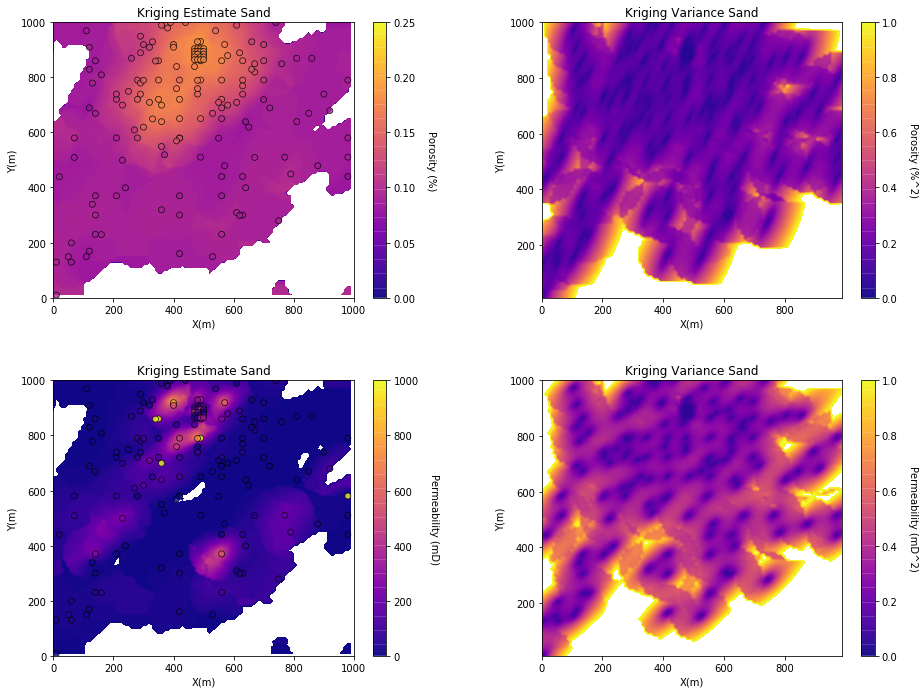

In [16]:
plt.subplot(221)
GSLIB.locpix_st(por_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_sand,'X','Y','Porosity','Kriging Estimate Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(por_sand_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance Sand','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df_sand,'X','Y','Perm','Kriging Estimate Sand','X(m)','Y(m)','Permeability (mD)',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(perm_sand_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance Sand','X(m)','Y(m)','Permeability (mD^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

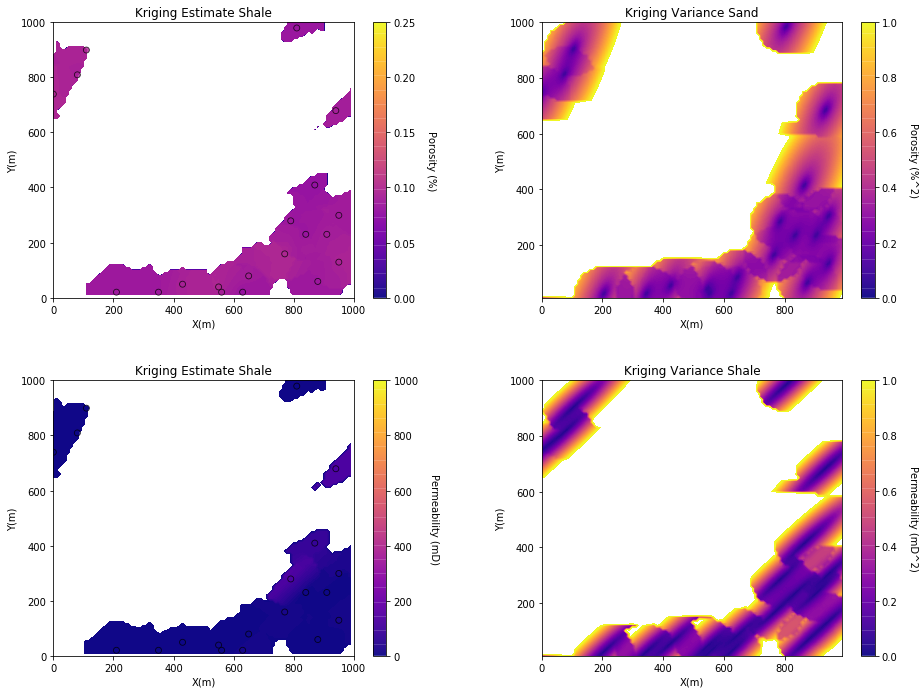

In [17]:
plt.subplot(221)
GSLIB.locpix_st(por_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_shale,'X','Y','Porosity','Kriging Estimate Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(por_shale_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance Sand','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df_shale,'X','Y','Perm','Kriging Estimate Shale','X(m)','Y(m)','Permeability (mD)',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(perm_shale_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance Shale','X(m)','Y(m)','Permeability (mD^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

# 3. Combined Model with Porosity and Permeability (cookie-cutter approach)


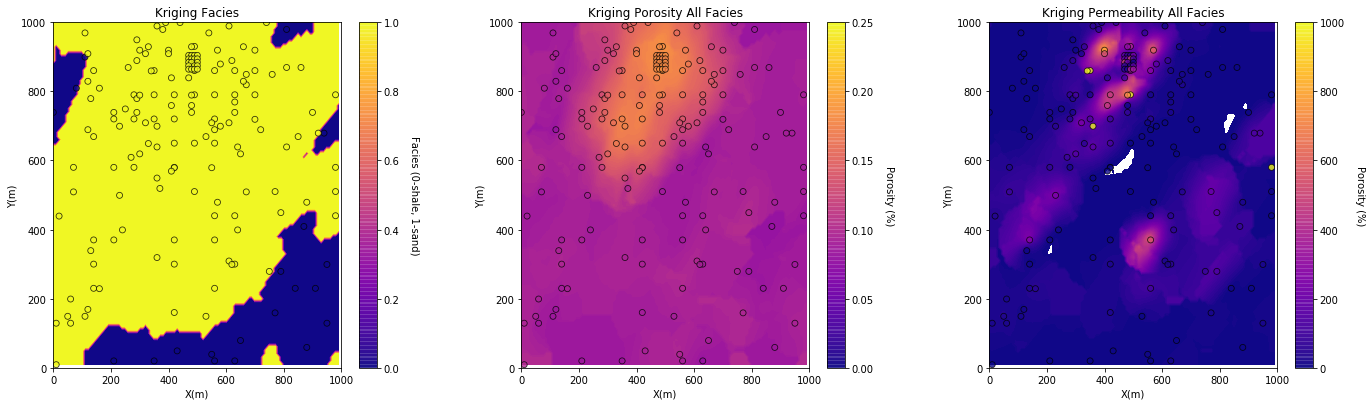

In [18]:
plt.subplot(131)
GSLIB.locpix_st(facies_kmap,xmin,xmax,ymin,ymax,xsiz,0,1,df,'X','Y','Facies','Kriging Facies','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(132)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Porosity All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(133)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','Perm','Kriging Permeability All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

# 4. Report Local P10 and P90 Map for Porosity and Permeability 

# 5. Pick 2 Candidate Well Locations, Provide a Predrill Porosity Uncertainty Distribution (linear family of distribution models) 